In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
np.random.seed(123) 

In [4]:
#preprocess
path = 'C:/Users/Fahad/Documents/Git/Project 6/Dataset/CT_COVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')

## covid negative images
path = 'C:/Users/Fahad/Documents/Git/Project 6/Dataset/CT_NonCOVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.png'}
negative image extensions: {'.png', '.jpg'}


In [5]:
#  list of images
path = 'C:/Users/Fahad/Documents/Git/Project 6/Dataset/CT_COVID'
pos_li = list(Path(path).glob('*.png'))

path = 'C:/Users/Fahad/Documents/Git/Project 6/Dataset/CT_NonCOVID'
neg_li = list(Path(path).glob('*.png'))
neg_li.extend(list(Path(path).glob('*.jpg')))

# display number of images
print(f'Postive images: {len(pos_li)}\nNegative images: {len(neg_li)}')

Postive images: 349
Negative images: 397


In [6]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 128
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ float data type must be used to save precise pixel values

In [7]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    pos_data[i] = img
## negative
for i, img_path in enumerate(sorted(neg_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    neg_data[i] = img

In [8]:
# scale image arrays
pos_data /= 255
neg_data /= 255

In [9]:
#Image segmentation with k-means clustering
# define function to perform image segmentation with k-means clustering
def k_means(img_array_list, K, criteria, attempts):
    new_img_array_list = []
    for array in img_array_list:
        # flatten array into 2D
        img = array.reshape(-1,1) # reshape into new dimensions; -1 refers to unknown dimension and will depend on others
                                  # (-1,1) will result in 2D with 1 column and n rows where 1 column x n rows is equal to  
                                  # the original number of elements. ex) (10,10) = (5,20) > both with 100 elements
                                  # 1 column is used since it's gray-scale image (3 used for RGB)
        ret, label, center = cv2.kmeans(img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#         center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape(128,128,1)
        new_img_array_list.append(result_image)
    return new_img_array_list

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
## positive
pos_data_seg = k_means(pos_data, K, criteria, attempts)
## negative
neg_data_seg = k_means(neg_data, K, criteria, attempts)

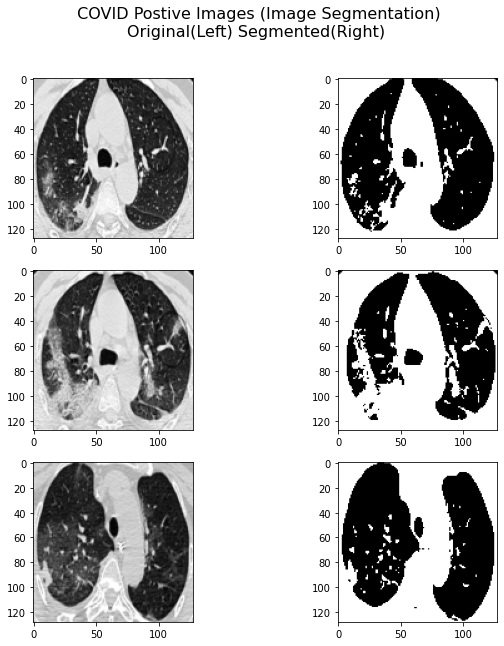

In [11]:
# show results for positive scans
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i, seg in enumerate(pos_data_seg):
    if i == 3:
        break
    ax[i, 0].imshow(pos_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle(' COVID Postive Images (Image Segmentation)\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

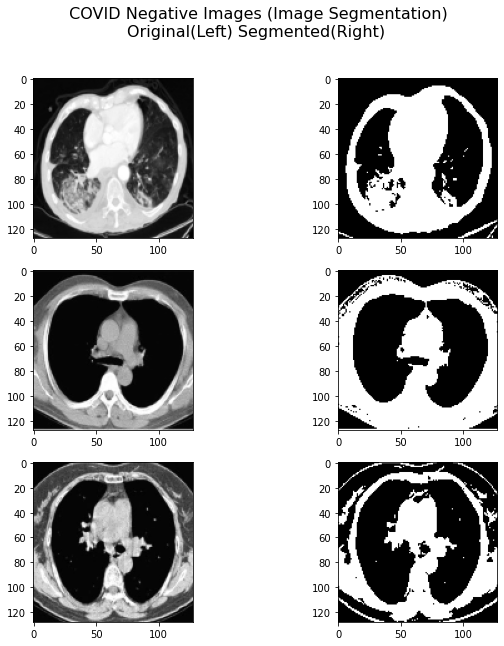

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i, seg in enumerate(neg_data_seg):
    if i == 3:
        break
    ax[i, 0].imshow(neg_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle(' COVID Negative Images (Image Segmentation)\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()


In [13]:
#Classification using VGG-16 model
# split data into train-validation datasets with 20% validation proportion
x_data = pos_data_seg + neg_data_seg  # segmented images
x_data = np.array(x_data, dtype='float32')

y_data = [1]*len(pos_data_seg) + [0]*len(neg_data_seg)
y_data = np.array(y_data, dtype='float32')

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3)

In [14]:
# callback options
"""
EarlyStopping IF accuracy doesn't improve in 15 epochs.
"""
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

In [ ]:
#Classification with segmented images

In [17]:
img_height = 128
img_width = 128
# define function to build 3-layer CNN model
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, 3, padding='same', activation='relu',input_shape=(img_height, img_width, 1))) 
    model.add(MaxPool2D()) 
    model.add(Conv2D(64, 5, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    
    return model

# build 3-layer CNN model
model_cnn_seg = build_cnn()

In [18]:
model_cnn_seg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
# train model
epochs=15
batch_size = 16
history_cnn_seg = model_cnn_seg.fit(x_train, y_train, validation_data=(x_val, y_val), 
                                    epochs=epochs, batch_size=batch_size, callbacks=[early])

Epoch 1/15
33/33 [==============================] - 21s 338ms/step - loss: 1.0259 - accuracy: 0.4959 - val_loss: 0.7431 - val_accuracy: 0.5134
Epoch 2/15
33/33 [==============================] - 11s 323ms/step - loss: 0.6417 - accuracy: 0.6449 - val_loss: 0.6629 - val_accuracy: 0.6161
Epoch 3/15
33/33 [==============================] - 11s 323ms/step - loss: 0.5524 - accuracy: 0.7407 - val_loss: 0.5837 - val_accuracy: 0.6696
Epoch 4/15
33/33 [==============================] - 11s 325ms/step - loss: 0.4414 - accuracy: 0.7947 - val_loss: 0.5983 - val_accuracy: 0.7009
Epoch 5/15
33/33 [==============================] - 11s 321ms/step - loss: 0.3002 - accuracy: 0.8850 - val_loss: 0.6031 - val_accuracy: 0.7054
Epoch 6/15
33/33 [==============================] - 11s 322ms/step - loss: 0.2462 - accuracy: 0.8940 - val_loss: 0.6060 - val_accuracy: 0.7321
Epoch 7/15
33/33 [==============================] - 11s 323ms/step - loss: 0.1883 - accuracy: 0.9346 - val_loss: 0.7232 - val_accuracy: 0.7143

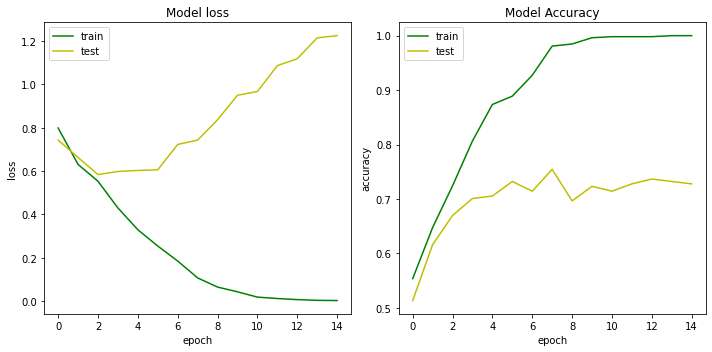

In [27]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# accuracy 
ax[1].set_title('Model Accuracy')
ax[1].plot(history_cnn_seg.history['accuracy'], 'g')
ax[1].plot(history_cnn_seg.history['val_accuracy'], 'y')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

# loss
ax[0].set_title('Model loss')
ax[0].plot(history_cnn_seg.history['loss'], 'g')
ax[0].plot(history_cnn_seg.history['val_loss'], 'y')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

plt.tight_layout()
plt.show()